In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add ,Bidirectional
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from matplotlib import pyplot
from numpy import expand_dims

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**NOTE:
For convience , try to run this over Kaggle. 
  Otherwise , download the dataset (its over 1gb) from the given link in the description.**
 **You could also use any other dataset**

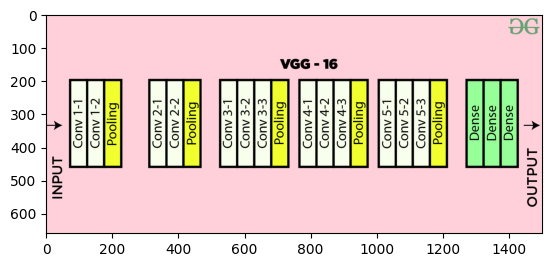

In [78]:
plt.imshow(load_img('/kaggle/input/convdata/conv-layers-vgg16.jpg'))

**Importing the VGG16 architecture.
Here I've used the VGG16 , for extracting image features.**

In [190]:

model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

### Visualising VGG16

In [225]:
def visualise(img_path):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # redefine model to output right after the first hidden layer
    ixs = [2, 5, 9, 13, 17]
    outputs = [model.layers[i].output for i in ixs]
    model = Model(inputs=model.inputs, outputs=outputs)
    # load the image with the required shape
    img = load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()  # Show the original image
    # convert the image to an array
    img = img_to_array(img)
    # expand dimensions so that it represents a single 'sample'
    img = expand_dims(img, axis=0)
    # prepare the image (e.g. scale pixel values for the vgg)
    img = preprocess_input(img)
    # get feature map for first hidden layer
    feature_maps = model.predict(img)
    # plot the output from each block
    # Plot the output from each block
    square = 8
    for i, fmap in enumerate(feature_maps):
        if i < len(ixs):  # Check if i is within the range of ixs
            # Plot all feature maps in an 8x8 grid
            ix = 1
            for _ in range(square):
                for _ in range(square):
                    # Specify subplot and turn off axis
                    ax = plt.subplot(square, square, ix)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    # Plot filter channel in grayscale
                    plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')
                    ix += 1
            # Show the figure
            plt.suptitle(f"Feature Maps in {model.layers[ixs[i]].name}", fontsize=14)
            plt.show()
        else:
            print("Not enough layers specified in ixs for all feature maps.")
            break


#### The plots you see below , are how the filters affect an image being processed by VGG16 , and the features that are examined in each convulation layer.


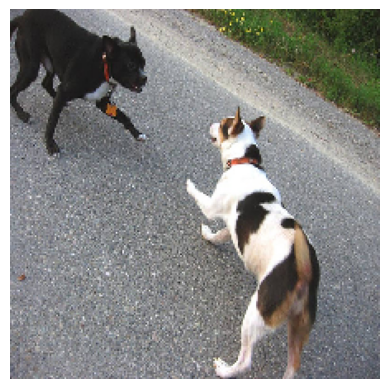

1/1 [==============================] - 0s 140ms/step


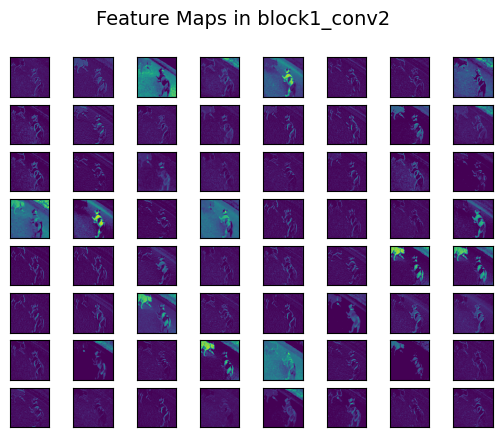

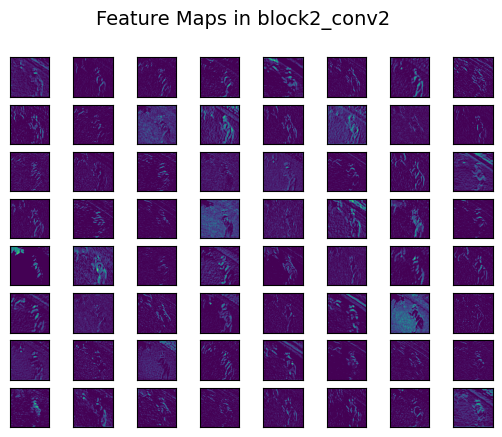

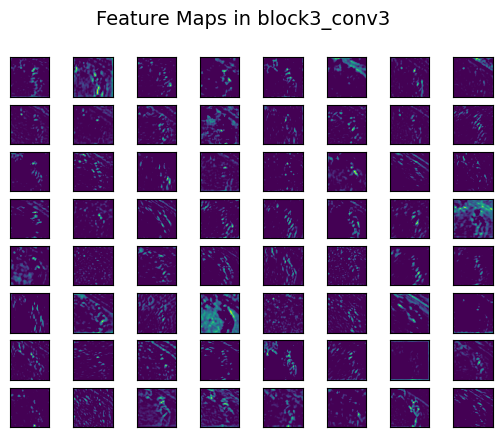

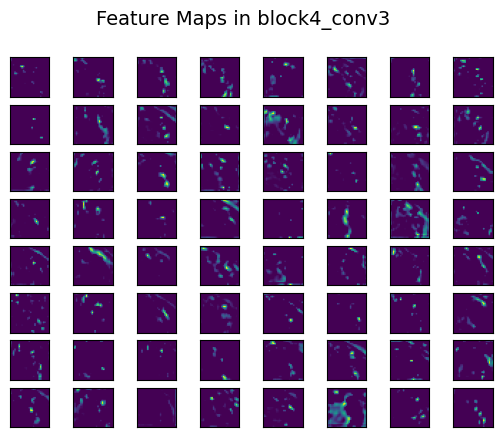

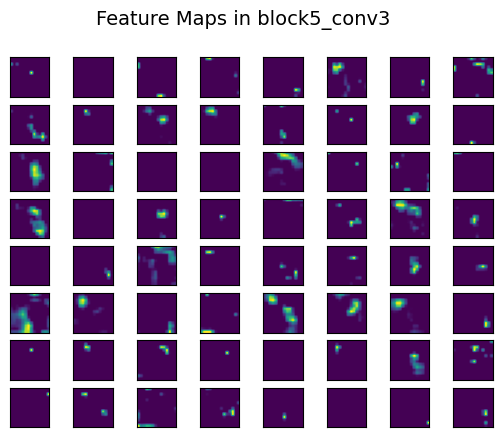

In [226]:
visualise('/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg')

#### Reinstating the model

In [ ]:

model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

### Here we're storing image and its vectors in a map. Which we'll be using later during training. This vector is acquired by processing the image through the VGG16 architecture. We dump this using pickle.

In [20]:
features = {}
directory = os.path.join('/kaggle/input/flickr8k/', 'Images')

for img_name in tqdm(os.listdir(directory)):

    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))

    image = img_to_array(image)

    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
 
    image = preprocess_input(image)
  
    feature = model.predict(image, verbose=0)
   
    image_id = img_name.split('.')[0]
   
    features[image_id] = feature


  0%|          | 0/20515 [00:00<?, ?it/s]

In [21]:
len(features)

20515

In [22]:

pickle.dump(features,open("features_flickr.pkl",'wb'))

In [3]:
features=pickle.load(open("/kaggle/input/features-flickr-pkl/features_flickr.pkl",'rb'))


**features_flickr.pkl is the pickle file of all extracted features of the images in the dataset(flickr8k)**

In [4]:
len(features)

8091

In [5]:
for x in list(features.keys())[0:5]:
    print(x)

3226254560_2f8ac147ea
214543992_ce6c0d9f9b
2366643786_9c9a830db8
3368819708_0bfa0808f8
2190227737_6e0bde2623


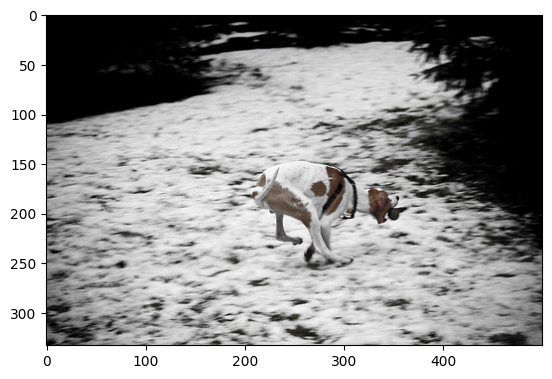

In [101]:
def show_img(image_path):
    image_show = Image.open(image_path)
    plt.imshow(image_show)
show_img("/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg")

In [7]:
features['3226254560_2f8ac147ea'][0]

array([0.       , 1.6273944, 0.       , ..., 0.       , 1.5637894,
       0.       ], dtype=float32)

In [8]:
import pandas as pd

**Reading in the caption data**

In [10]:
#Reading caption
with open(os.path.join("/kaggle/input/flickr8k", 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [11]:
captions_doc[:100]

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1'

In [12]:
captions_doc.split('\n')[0].split(',')[0] , captions_doc.split('\n')[0].split(',')[1]

('1000268201_693b08cb0e.jpg',
 'A child in a pink dress is climbing up a set of stairs in an entry way .')

In [13]:
captions_doc.split('\n')[:3]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .']

##### An image has many captions so lets convert it to a key:list format

In [14]:

    
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)
    

100%|██████████| 40456/40456 [00:00<00:00, 365195.41it/s]


In [15]:
len(mapping)

8091

In [16]:
print({k: mapping[k] for k in list(mapping)[:5]})

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .'], '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'], '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting

##### Now we clean the textual data and add tokens in the start and end . This will let the model know when a sentence starts and ends.

In [17]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [18]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [19]:
mapping['3226254560_2f8ac147ea']

['A dog in a snowy area .',
 'A spotted dog catching a ball on a snowy field .',
 'A white and brown spotted dog runs along the snow to catch a ball .',
 'A white dog is running fast on a trail covered by snow .',
 'The brown and white dog is playing in the snow .']

In [20]:
clean(mapping)

In [21]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [22]:
all_caption=[]
for cap in mapping:
    for cc in mapping[cap]:
        all_caption.append(cc)

In [23]:
all_caption[0]

'startseq child in pink dress is climbing up set of stairs in an entry way endseq'

In [26]:
len(all_caption)

40455

#### **Setting up the Tokenizer**

##### A tokenizer is a tool used in natural language processing (NLP) to break down a text into smaller units, typically words or subwords. These smaller units are called tokens. Tokenization is often the first step in many NLP tasks, such as text classification, sentiment analysis, and machine translation.

In [27]:
#tokenize
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_caption)

In [76]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8485


In [29]:
#Max len caption
max_length=max(len (x.split()) for x in all_caption)
print(max_length)

35


In [30]:
image_index=list(mapping.keys())
split=int(len(image_index)*0.90)
train=image_index[:split]
test=image_index[split:]

In [31]:
seq=tokenizer.texts_to_sequences([all_caption[0]])[0]
for i in range(1, len(seq)):
    in_seq, out_seq = seq[:i], seq[i]
    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]             
    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
print(in_seq)
print(out_seq)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    1   42    3   90  172    6  119   50
  393   11  394    3   27 5146  670]
[0. 0. 1. ... 0. 0. 0.]


**This code defines a data generator for training a neural network in a sequence-to-sequence learning task, such as image captioning.**

**Input Parameters:
data_keys: Keys to access data.
mapping: Dictionary mapping keys to lists of captions.
features: Dictionary containing features (e.g., image vectors).
tokenizer: Tokenizer for converting captions to sequences of integers.
max_length: Maximum length of a sequence.
vocab_size: Size of the vocabulary.
batch_size: Size of each training batch.**

**Generator Loop:
Iterates infinitely, yielding batches of training data.
For each iteration:
Iterates through data keys and associated captions.
Tokenizes captions, pads sequences, and converts output sequences to one-hot encoding.
Appends image features, input sequences, and output sequences to respective lists.
When batch size is reached, yields the batch, resets lists, and batch counter.**

**Purpose: It efficiently prepares training data on-the-fly, reducing memory usage and enabling training on large datasets.**

In [34]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0


**Creating the architeture. Concatinating the two models , image and text.**

**This model integrates both image and sequence features to generate captions, with the image features processed by a dense layer and the sequence features processed by an LSTM layer. The outputs are probabilities of each word in the vocabulary, enabling the model to predict the next word in a caption.**

**Image Feature Input:
Input layer (inputs1) for image features with shape (4096,).
Dropout layer (fe1) with dropout rate 0.4 applied to image features.
Dense layer (fe2) with 256 units and ReLU activation applied to dropout layer.**

**Sequence Feature Input:
Input layer (inputs2) for sequence features with variable length (defined by max_length).
Embedding layer (se1) with vocabulary size as input dimension, embedding size 256, and masking enabled to handle variable-length sequences.
Dropout layer (se2) with dropout rate 0.4 applied to the embedding layer.
LSTM layer (se3) with 256 units processing the dropout layer.**

**Decoder Model:
Features from both image and sequence are concatenated (decoder1).
Dense layer (decoder2) with 256 units and ReLU activation applied to concatenated features.
Output layer (outputs) with vocabulary size units and softmax activation, predicting the next word in the sequence.**

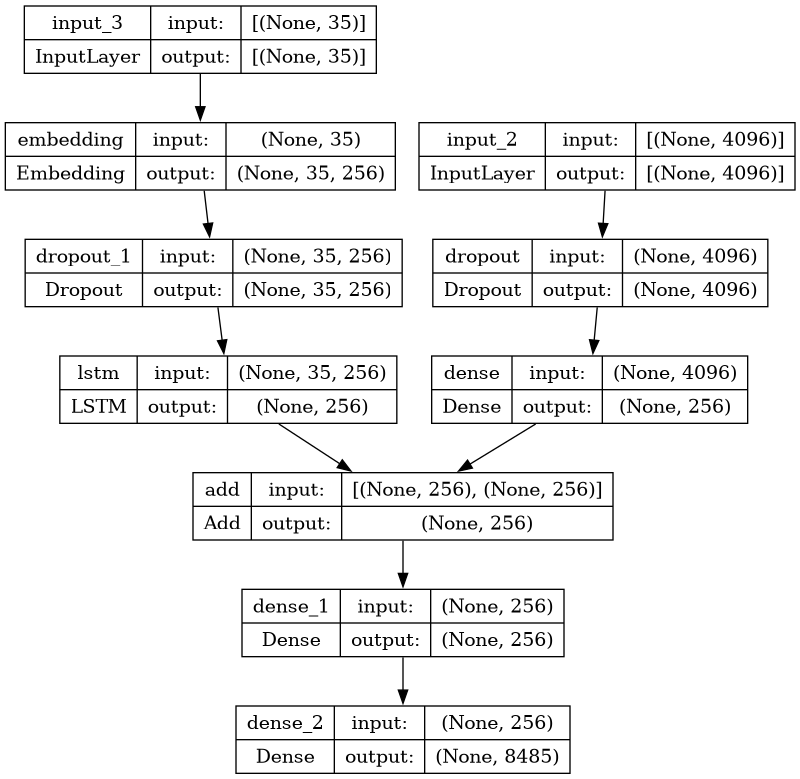

In [31]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True , to_file="/kaggle/working/model_plot.png")

In [32]:
epochs = 80
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    print("EPOCH NUMBER:",i)
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=2, steps_per_epoch=steps, verbose=1)

EPOCH NUMBER: 0
Epoch 1/2
227/227 [==============================] - 62s 246ms/step - loss: 5.2260
Epoch 2/2
227/227 [==============================] - 43s 190ms/step - loss: 4.0161
EPOCH NUMBER: 1
Epoch 1/2
227/227 [==============================] - 41s 182ms/step - loss: 3.5834
Epoch 2/2
227/227 [==============================] - 42s 184ms/step - loss: 3.3101
EPOCH NUMBER: 2
Epoch 1/2
227/227 [==============================] - 42s 186ms/step - loss: 3.1127
Epoch 2/2
227/227 [==============================] - 42s 183ms/step - loss: 2.9604
EPOCH NUMBER: 3
Epoch 1/2
227/227 [==============================] - 41s 182ms/step - loss: 2.8419
Epoch 2/2
227/227 [==============================] - 43s 189ms/step - loss: 2.7473
EPOCH NUMBER: 4
Epoch 1/2
227/227 [==============================] - 42s 183ms/step - loss: 2.6689
Epoch 2/2
227/227 [==============================] - 42s 184ms/step - loss: 2.4828
EPOCH NUMBER: 6
Epoch 1/2
227/227 [==============================] - 43s 189ms/step - loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



227/227 [==============================] - 42s 186ms/step - loss: 1.9781
Epoch 2/2
227/227 [==============================] - 42s 183ms/step - loss: 1.9647
EPOCH NUMBER: 15
Epoch 1/2
227/227 [==============================] - 41s 182ms/step - loss: 1.9454
Epoch 2/2
227/227 [==============================] - 42s 184ms/step - loss: 1.9313
EPOCH NUMBER: 16
Epoch 1/2
227/227 [==============================] - 42s 183ms/step - loss: 1.9160
Epoch 2/2
227/227 [==============================] - 42s 184ms/step - loss: 1.9061
EPOCH NUMBER: 17
Epoch 1/2
227/227 [==============================] - 43s 189ms/step - loss: 1.8906
Epoch 2/2
227/227 [==============================] - 42s 187ms/step - loss: 1.8739
EPOCH NUMBER: 18
Epoch 1/2
227/227 [==============================] - 43s 188ms/step - loss: 1.8627
Epoch 2/2
227/227 [==============================] - 42s 187ms/step - loss: 1.8457
EPOCH NUMBER: 19
Epoch 1/2
227/227 [==============================] - 43s 189ms/step - loss: 1.8338
Epoch 2/2
22

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



227/227 [==============================] - 43s 190ms/step - loss: 1.4473
EPOCH NUMBER: 48
Epoch 1/2
227/227 [==============================] - 43s 189ms/step - loss: 1.4416
Epoch 2/2
227/227 [==============================] - 43s 190ms/step - loss: 1.4350
EPOCH NUMBER: 49
Epoch 1/2
227/227 [==============================] - 42s 183ms/step - loss: 1.4340
Epoch 2/2
227/227 [==============================] - 42s 184ms/step - loss: 1.4320
EPOCH NUMBER: 50
Epoch 1/2
227/227 [==============================] - 43s 188ms/step - loss: 1.4274
Epoch 2/2
227/227 [==============================] - 43s 188ms/step - loss: 1.4249
EPOCH NUMBER: 51
Epoch 1/2
227/227 [==============================] - 42s 187ms/step - loss: 1.4208
Epoch 2/2
227/227 [==============================] - 42s 186ms/step - loss: 1.4191
EPOCH NUMBER: 52
Epoch 1/2
227/227 [==============================] - 40s 176ms/step - loss: 1.4161
Epoch 2/2
227/227 [==============================] - 40s 175ms/step - loss: 1.4121
EPOCH NUMBER

In [33]:
model.save('/kaggle/working/captioning.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Apparently .h5 , is depricated so I've used keras model.save method to save the model..

In [43]:
model.save('/kaggle/working/captioning_tf.keras')

**Extracting the tokenizer as pickle file**

In [25]:
pickle.dump(tokenizer,open("/kaggle/working/Tokenizer.pkl",'wb'))

NameError: name 'tokenizer' is not defined

### **Setting up preprocessing and pipeline for generation.**

In [49]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [50]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [39]:

def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [53]:
vgg_model = VGG16() 

vgg_model = Model(inputs=vgg_model.inputs,             
                  outputs=vgg_model.layers[-2].output)

In [57]:
from keras.models import load_model

model=load_model('/kaggle/working/captioning_tf.keras')

In [54]:
def generate_caption(image_path):
    
    image_show = Image.open(image_path)
    
    
    image = load_img(image_path, target_size=(224, 224))

    image = img_to_array(image)

    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    image = preprocess_input(image)
    # extract features
    feature = vgg_model.predict(image, verbose=0)
    # predict from the trained model
    pre=predict_caption(model, feature, tokenizer, max_length)
    pre=' '.join(pre.split()[1:-1])
    plt.title(pre)
    print(pre)
    plt.imshow(image_show)
    return(pre)

**Testing with an image.**

man lays on bench in front of white dog and black dog


'man lays on bench in front of white dog and black dog'

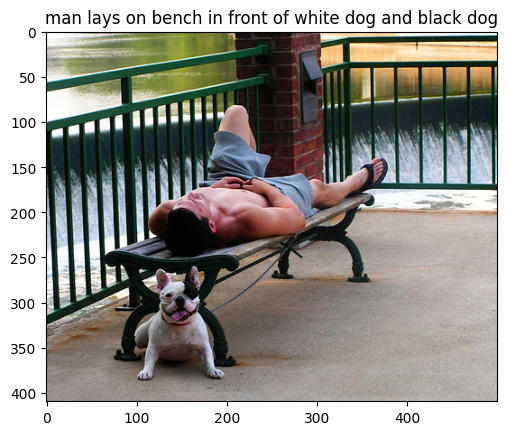

In [58]:
generate_caption("/kaggle/input/flickr8k/Images/1003163366_44323f5815.jpg")


**Its working!!**
**If you have any doubt , you can reach me out via my GitHub https://github.com/HazSyl1**

***Working on the accuracy***

In [42]:
test_map = {key: mapping[key] for key in test if key in mapping}


In [61]:
len(test_map)

810

In [65]:
len(test_map)

810

IMAGE: 997722733_0cb5439472
man doing tricks on skateboard
IMAGE: 997722733_0cb5439472
dog is walking along sidewalk with its head around him
IMAGE: 997722733_0cb5439472
three men in period costume are posing for picture
IMAGE: 997722733_0cb5439472
three men are looking at light on train
IMAGE: 997722733_0cb5439472
man is sitting at desk in library
IMAGE: 997722733_0cb5439472
a woman in red and red gloves on red skiing
IMAGE: 997722733_0cb5439472
boy in red shirt and blue pants is climbing on red horse
IMAGE: 997722733_0cb5439472
two children are playing in field of red and blue sky
IMAGE: 997722733_0cb5439472
parachute using an open line over the mountains
IMAGE: 997722733_0cb5439472
woman sits on sailboat in the front of the ocean
IMAGE: 997722733_0cb5439472
brown and white dog is running in the grass
IMAGE: 997722733_0cb5439472
two children are sitting on the couch
IMAGE: 997722733_0cb5439472
dog is playing with toy in the backyard
IMAGE: 997722733_0cb5439472
little girl in pink dre

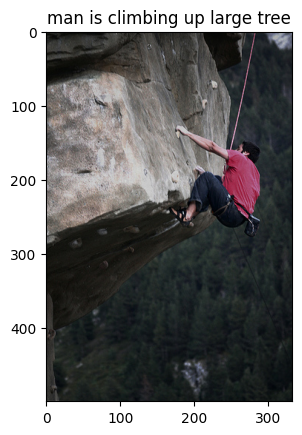

In [66]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()
for img_id, desc_list in test_map.items():
    image_path=os.path.join("/kaggle/input/flickr8k/Images",img_id+'.jpg')
    print("IMAGE:",img_id)
    yhat = generate_caption(image_path)
    #print("YHAT:",yhat)
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
test_bleu = corpus_bleu(actual, predicted)


In [69]:
print(f"Blue Score:{test_bleu}")

Blue Score:0.2172601986759069


## **BLEU_SCORE=0.22**

## ***It's doing fairly well , on the test set with a score of around 0.2. Which is considerable good. (A score of >=5 is considered the best u can get.)***

### Testing how it works with unseen data

***For Evaluation I'm using flickr-image-dataset-30k. I'll be only using the first 1000 instances of caption for the evaluation***

In [116]:
def load_dataset(images_folder, csv_path):
    descriptions = pd.read_csv(csv_path,delimiter='|')
    #description=description.head(1000)
    images = {}
    captions = {}
    for i, row in descriptions.iterrows():
        if(i==1000):
            break
        img_id = row['image_name'].split('.')[0]
        caption = row[' comment']
        image_path = os.path.join(images_folder, img_id+'.jpg')
        if img_id not in images:
            images[img_id] = image_path
            captions[img_id] = []
        captions[img_id].append(caption)
    return images, captions

In [117]:
images, desc=load_dataset('/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images','/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv')

In [119]:
len(images) ,len(desc)

(200, 200)

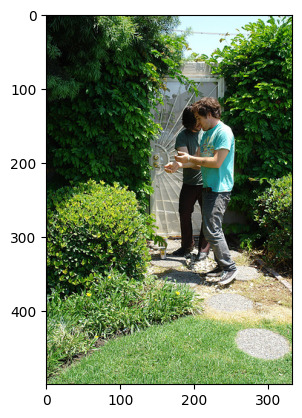

In [120]:
show_img(images['1000092795'])

In [121]:
desc['1000092795']

[' Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 ' Two young , White males are outside near many bushes .',
 ' Two men in green shirts are standing in a yard .',
 ' A man in a blue shirt standing in a garden .',
 ' Two friends enjoy time spent together .']

In [130]:
from nltk.translate.bleu_score import corpus_bleu
def evaluate_model(model, vgg_model, tokenizer, images, descriptions, max_length):
    actual, predicted = list(), list()
    for img_id, desc_list in descriptions.items():
        image_path = images[img_id]
        yhat = generate_caption(image_path)
        #print("YHAT:",yhat)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    bleu = corpus_bleu(actual, predicted)
    return bleu

woman in striped shirt and toddler in white shirt and white shorts are sitting on bench in park
young man is playing with pole while another man lays on
little girl in striped dress and green tie is climbing on wooden picnic table bench
man grinds his bicycle by rundown building
man in blue shirt and man in headphones
man reacts to another man who is holding stick
the dog has striped shirt on
woman in white shirt and hat is walking
two people are reading book
skateboarder doing trick on trick high in the air
two girls are reading at an empty screen
three people are posing for picture
two dogs play with each other while playing with red ball
man relaxes on paved road outside looking their vehicle
girl in sunglasses and top looking onward
young girl is looking at display of paper being sprayed in the air by her
little girl in red shirt is sitting in front of large crowd
man lays on bench in front of white dog and black dog
three people sitting at table with wine
man with headphones aroun

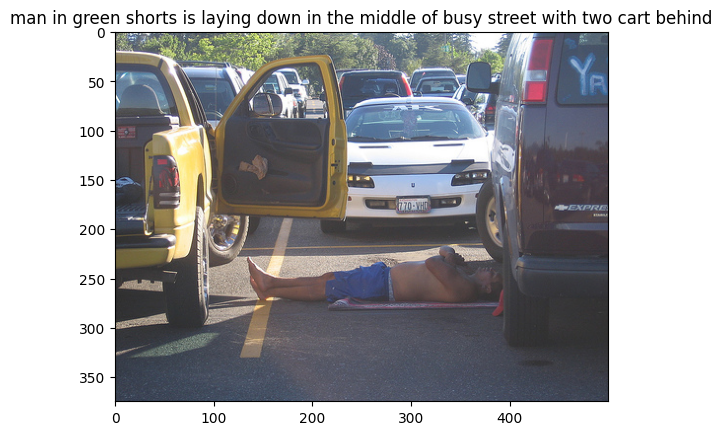

In [131]:
bleu_score = evaluate_model(model, vgg_model, tokenizer, images, desc, max_length)


In [71]:
print(f'BLEU score: {bleu_score:.2f}')


BLEU score: 0.12


### **Evaluation BLEU SCORE:0.12**

**A blue score of over 0.5 is considered state of the art. Considering we've only trained this for 80 epochs on a limited dataset, its considerably good. By increasing the training epochs and dataset we can get a better result.**

## Lets test 

woman wearing colorful costume is holding her hand up to her face


'woman wearing colorful costume is holding her hand up to her face'

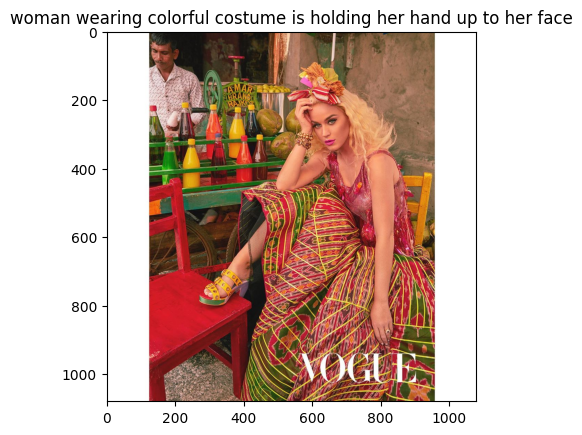

In [139]:
generate_caption('/kaggle/input/instagram-images-with-captions/instagram_data2/img2/insta20525.jpg')

little boy examines piece of jewelry


'little boy examines piece of jewelry'

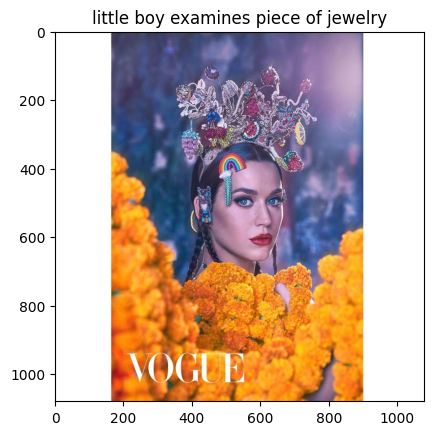

In [140]:
generate_caption('/kaggle/input/instagram-images-with-captions/instagram_data2/img2/insta20528.jpg')

two girls are posing for picture on playground


'two girls are posing for picture on playground'

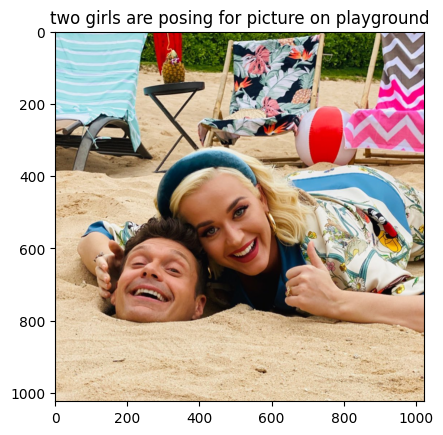

In [142]:
generate_caption('/kaggle/input/instagram-images-with-captions/instagram_data2/img2/insta20519.jpg')

girl in flower swimsuit is posing with long red hair at the beach


'girl in flower swimsuit is posing with long red hair at the beach'

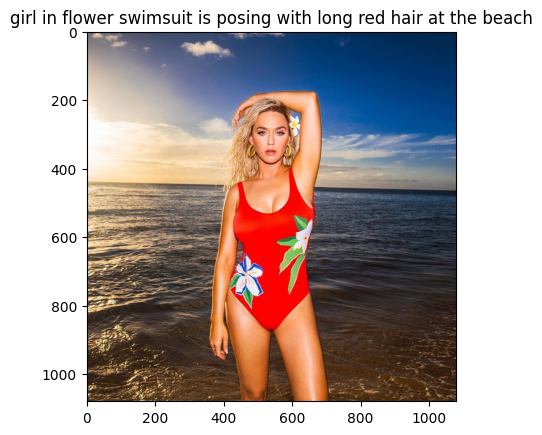

In [146]:
generate_caption('/kaggle/input/instagram-images-with-captions/instagram_data2/img2/insta20549.jpg')

**Its working!!**
**If you have any doubt , you can reach me out via my GitHub https://github.com/HazSyl1**